# Advanced Machine Learning

## Assignment #3

<a href="https://colab.research.google.com/drive/1_2CPDWHgdboAkChgtjc0F5QbRszuf21F?authuser=1#scrollTo=k2PSF0qVzuvJ">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" width=150 align='left'/>
</a>

### Import packages

In [2]:
# Base

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = 15,5

# Preprocessing and model
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
from keras.utils import plot_model, to_categorical

from keras.models import Model
from keras.layers import (Input, Dense, Flatten,
                          Dropout, Conv2D, MaxPooling2D)

from keras.layers.normalization import BatchNormalization
from keras import regularizers
from sklearn.metrics import classification_report
from livelossplot.keras import PlotLossesCallback

Define function to plot training results (deprecated because of PlotLossesCallback)

In [15]:
# def model_plot(history):
#     plt.figure(figsize = (15, 5))
#     plt.plot(history.history['acc'])
#     plt.plot(history.history['val_acc'])
#     plt.title('model accuracy')
#     plt.ylabel('accuracy')
#     plt.xlabel('epoch')
#     plt.legend(['train', 'val'], loc = 'upper left')
#     plt.show()

#     plt.figure(figsize = (15, 5))
#     plt.plot(history.history['loss'])
#     plt.plot(history.history['val_loss'])
#     plt.title('model loss')
#     plt.ylabel('loss')
#     plt.xlabel('epoch')
#     plt.legend(['train', 'val'], loc = 'upper left')
#     plt.show()

### Data

First of all we import our mnist dataset from keras.datasets

In [4]:
print('Loading data...')
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Loading data...


Quick overview on ylabel distribution for training and test set

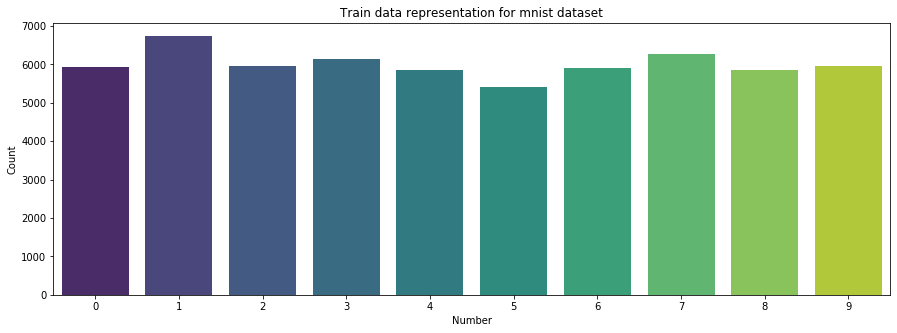

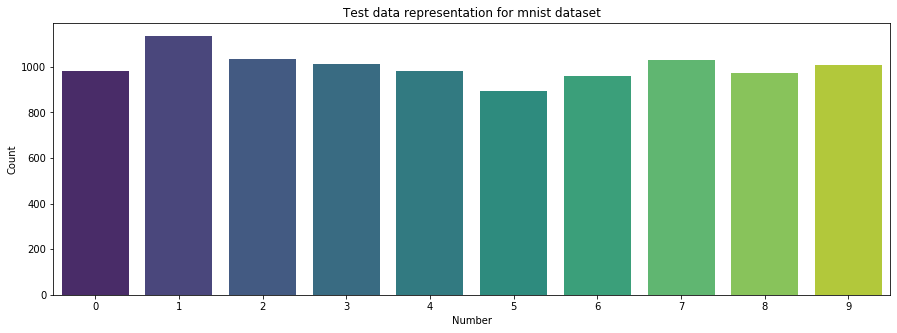

In [5]:
sns.countplot(y_train, palette = 'viridis')
plt.title("Train data representation for mnist dataset")
plt.ylabel("Count")
plt.xlabel("Number")
plt.show()

sns.countplot(y_test, palette = 'viridis')
plt.title("Test data representation for mnist dataset")
plt.ylabel("Count")
plt.xlabel("Number")
plt.show()

Pretty uniform distributions

Plot some istances

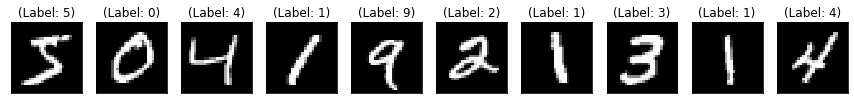

In [6]:
n = 10
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i], cmap = "gray")
    plt.title("(Label: " + str(y_train[i]) + ")")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

### Preprocessing

Time to preprocess our data

First of all we create Validation set from our Training set 10%-90%

In [7]:
print("Splitting...")
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.10, random_state = 32, stratify = y_train)
print("Training set (images) shape: {shape}".format(shape=x_train.shape))
print("Validation set (images) shape: {shape}".format(shape=x_val.shape))
print("Test set (images) shape: {shape}".format(shape = x_test.shape))

Splitting...
Training set (images) shape: (54000, 28, 28)
Validation set (images) shape: (6000, 28, 28)
Test set (images) shape: (10000, 28, 28)


Then we rescale training, validation and test set from [0,255] to [0,1] interval

In [8]:
print("Rescaling...")
x_train = x_train.astype('float32')/np.max(x_train)
x_test = x_test.astype('float32')/np.max(x_test)
x_val = x_val.astype('float32')/np.max(x_val)

print(np.max(x_train), np.max(x_val), np.max(x_test))
print("Done")

Rescaling...
1.0 1.0 1.0
Done


Now it's time to change y encoding to one-hot encoding

In [9]:
train_y_one_hot = to_categorical(y_train, num_classes = 10)
val_y_one_hot = to_categorical(y_val, num_classes = 10)
test_y_one_hot = to_categorical(y_test, num_classes = 10)

print("Example:")
print('Original label:', y_train[0])
print('After conversion to one-hot:', train_y_one_hot[0])

Example:
Original label: 2
After conversion to one-hot: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


Last but not least we use reshape on our train, test and validation set in order to make explicitly referece to the fact that we have gray scale images, so we have only one channel in our images

In [10]:
print("Reshaping...")

x_train = x_train.reshape(-1, 28,28, 1)
x_test = x_test.reshape(-1, 28,28, 1)
x_val = x_val.reshape(-1, 28,28, 1)

print("Training set (images) shape: {shape}".format(shape = x_train.shape))
print("Validation set (images) shape: {shape}".format(shape = x_val.shape))
print("Test set (images) shape: {shape}".format(shape = x_test.shape))

Reshaping...
Training set (images) shape: (54000, 28, 28, 1)
Validation set (images) shape: (6000, 28, 28, 1)
Test set (images) shape: (10000, 28, 28, 1)


### Model

Goal of this assignment is to create a classification model using CNN but not exceeding 7500 parameters in our NN

In [11]:
batch_size = 1024
epochs = 100
inChannel = x_train.shape[3]
x, y = x_train.shape[1], x_train.shape[2]
input_img = Input(shape = (x, y, inChannel))
num_classes = len(np.unique(y_train))

In [12]:
def init_model(input_img):
    conv1 = Conv2D(10, (3, 3), activation = 'relu', padding='same')(input_img) #28 x 28 x 10
    pool1 = MaxPooling2D(pool_size=(2,2), strides = 2)(conv1) #14x14x10
    norm1 = BatchNormalization()(pool1)
    conv2 = Conv2D(4, (3, 3), activation='relu', padding='same')(norm1) #14x14x4
    pool2 = MaxPooling2D(pool_size=(2, 2), strides = 2)(conv2) #7x7x4
    norm2 = BatchNormalization()(pool2)
    flat = Flatten()(norm2) #196
    fc1 = Dense(32, activation = 'relu')(flat)
    drop1 = Dropout(rate = .1)(fc1)
    out = Dense(num_classes, activation = 'softmax')(drop1)
    return out

In [13]:
full_model = Model(input_img, init_model(input_img))

full_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['acc'])

full_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 10)        100       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 10)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 10)        40        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 4)         364       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 4)           0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 7, 4)           16  

full_model.summary() gave us the number of parameters in this model. ~ 7100

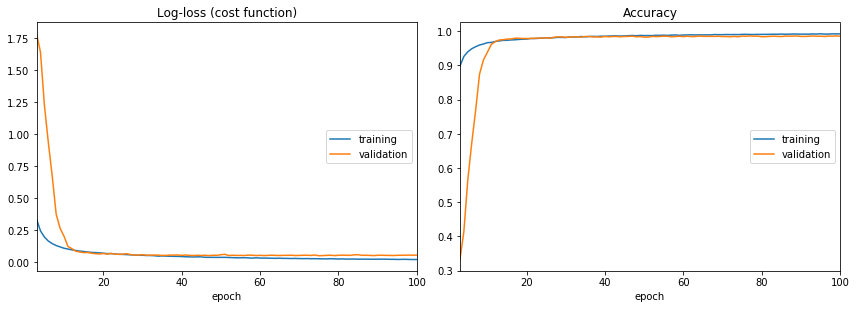

Log-loss (cost function):
training   (min:    0.022, max:    1.592, cur:    0.022)
validation (min:    0.052, max:    1.794, cur:    0.057)

Accuracy:
training   (min:    0.481, max:    0.993, cur:    0.992)
validation (min:    0.331, max:    0.987, cur:    0.986)


In [14]:
classify_train = full_model.fit(x_train, train_y_one_hot, 
                                batch_size = batch_size, epochs = epochs,
                                verbose = 0, validation_data = (x_val, val_y_one_hot),
                               callbacks = [PlotLossesCallback()])

In [22]:
predicted = full_model.predict(x_test)
y_pred = np.argmax(predicted, axis = 1)

print(classification_report(y_test, y_pred, digits = 4))

              precision    recall  f1-score   support

           0     0.9888    0.9949    0.9919       980
           1     0.9965    0.9921    0.9943      1135
           2     0.9893    0.9874    0.9884      1032
           3     0.9814    0.9911    0.9862      1010
           4     0.9888    0.9878    0.9883       982
           5     0.9778    0.9877    0.9827       892
           6     0.9894    0.9739    0.9816       958
           7     0.9893    0.9883    0.9888      1028
           8     0.9767    0.9897    0.9832       974
           9     0.9879    0.9742    0.9810      1009

    accuracy                         0.9868     10000
   macro avg     0.9866    0.9867    0.9866     10000
weighted avg     0.9868    0.9868    0.9868     10000



Good performances on test set, no overfitting, good generalization

<hr>

FROM HERE DEPRECATED

In [17]:
# classify_train = full_model.fit(x_train, train_y_one_hot, 
#                                 batch_size = batch_size, epochs = epochs,
#                                 verbose = 0, validation_data = (x_val, val_y_one_hot),
#                                callbacks = [PlotLossesCallback()])

In [18]:
# model_plot(classify_train)

# predicted = full_model.predict(x_test)
# y_pred = np.argmax(predicted, axis = 1)

# print(classification_report(y_test, y_pred))